# End To End Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file using Runway v0.12.0

In [2]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, PyIngest, UserInput
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Load and Describe Data

The USER_GENERATED_INPUT variable contains a general discription and feature descriptions for each feature we'd like to use in our graph.

In [3]:
USER_GENERATED_INPUT = UserInput(general_description='This is data on different cities.',
                                 column_descriptions={
                                     'id': 'unique id for a city.',
                                    'name': 'the city name.',
                                   'state_id': "the id for the state.",
                                   'country_id': 'the id for the country.'
                                    },
                                use_cases=[
        "Organize a hierarchy of locations"
    ]  
                                )

In [4]:
data = pd.read_csv("../../../data/countries/cities.csv")

In [5]:
data.head()

,id,name,state_id,state_code,state_name,country_id,country_code,country_name,latitude,longitude,wikiDataId
0,52,Ashkāsham,3901,BDS,Badakhshan,1,AF,Afghanistan,36.68333,71.53333,Q4805192
1,68,Fayzabad,3901,BDS,Badakhshan,1,AF,Afghanistan,37.11664,70.58002,Q156558
2,78,Jurm,3901,BDS,Badakhshan,1,AF,Afghanistan,36.86477,70.83421,Q10308323
3,84,Khandūd,3901,BDS,Badakhshan,1,AF,Afghanistan,36.95127,72.31800,Q3290334
4,115,Rāghistān,3901,BDS,Badakhshan,1,AF,Afghanistan,37.66079,70.67346,Q2670909


## Initialize LLMs

We now initialize the LLMs to use in data discovery and data model creation.

In [6]:
llm_disc = OpenAIDiscoveryLLM(model_name='gpt-4o-mini-2024-07-18', model_params={"temperature": 0})
llm_dm = OpenAIDataModelingLLM(model_name='gpt-4o-2024-05-13', model_params={"temperature": 0.5})

## Discovery

We now load the above data into a Discovery object.

In [7]:
disc = Discovery(llm=llm_disc, user_input=USER_GENERATED_INPUT, data=data)

In [8]:
disc.run(show_result=True, notebook=True)

The dataset contains information about 150,454 cities, with four key features: `id`, `name`, `state_id`, and `country_id`. Here are some important details and insights from the preliminary analysis:

1. **Data Overview**:
   - The dataset has a total of 150,454 entries, indicating a substantial amount of data for analysis.
   - There is one missing value in the `name` column, which may need to be addressed depending on the analysis requirements.

2. **Feature Characteristics**:
   - **id**: This is a unique identifier for each city. The distribution shows a wide range of values from 1 to 153,528, with a mean of approximately 76,407. The standard deviation is relatively high (44,357), indicating a diverse range of city IDs.
   - **name**: The city names are mostly unique, with 131,996 unique entries out of 150,453. The most frequent city name is "Merkez", which appears 51 times. This suggests that there may be multiple cities with the same name, possibly in different states or countries.
   - **state_id**: This feature represents the state each city belongs to. The `state_id` values range from 1 to 5,116, with a mean of approximately 2,678. The distribution indicates a variety of states represented in the dataset, which is crucial for organizing a hierarchy of locations.
   - **country_id**: This feature indicates the country each city is located in. The `country_id` ranges from 1 to 247, with a mean of about 140. The distribution suggests that there are many countries represented, which is important for understanding the geographical context of the cities.

3. **Missing Values**:
   - The only missing value is in the `name` column. Depending on the analysis, this may need to be filled or removed.

4. **Use Case Relevance**:
   - For organizing a hierarchy of locations, the `state_id` and `country_id` features are particularly important. They can be used to establish relationships between cities, states, and countries, allowing for a structured representation of geographical data.
   - The `id` feature can serve as a unique identifier for each city, while the `name` feature provides human-readable labels for the cities.

5. **Potential Data Quality Issues**:
   - The presence of duplicate city names may indicate potential data quality issues, especially if cities with the same name are located in different states or countries. This should be investigated further to ensure accurate representation in the graph model.

Overall, the dataset provides a rich source of information for analyzing cities and their geographical relationships. The most important features for the use case of organizing a hierarchy of locations are `state_id` and `country_id`, as they will help establish the relationships between different levels of geographical data.

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [9]:
gdm = GraphDataModeler(
    llm=llm_dm,
    discovery=disc
)

We now generate our first pass data model.

In [10]:
gdm.create_initial_model(max_retries=5)

> Generating Nodes...
Attempts | 1  
Received Valid Nodes
Nodes
* (:City)      * (:State)
* (:Country)    

> Generating Data Model...
Attempts | 1  
Recieved Valid Data Model
Nodes
* (:City)      * (:State)
* (:Country)    

Relationships
* (:City)-[:LOCATED_IN]->(:State)   
* (:State)-[:PART_OF]->(:Country)   


DataModel(nodes=[Node(label='City', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='State', properties=[Property(name='stateId', type='int', column_mapping='state_id', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Country', properties=[Property(name='countryId', type='int', column_mapping='country_id', alias=None, is_unique=True, part_of_key=False)], source_name='file')], relationships=[Relationship(type='LOCATED_IN', properties=[], source='City', target='State', source_name='file'), Relationship(type='PART_OF', properties=[], source='State', target='Country', source_name='file')], metadata=None)

In [11]:
gdm.current_model

DataModel(nodes=[Node(label='City', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='State', properties=[Property(name='stateId', type='int', column_mapping='state_id', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Country', properties=[Property(name='countryId', type='int', column_mapping='country_id', alias=None, is_unique=True, part_of_key=False)], source_name='file')], relationships=[Relationship(type='LOCATED_IN', properties=[], source='City', target='State', source_name='file'), Relationship(type='PART_OF', properties=[], source='State', target='Country', source_name='file')], metadata=None)

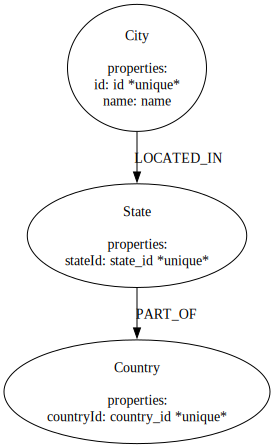

In [12]:
gdm.current_model.visualize()

We can clean this up a bit, so let's prompt the LLM to make some corrections.

We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We can provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [13]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         file_directory="data/csv/", source_name="cities.csv")

In [14]:
pyingest_yaml = gen.generate_config_string()
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT city_id IF NOT EXISTS FOR (n:City) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT state_stateid IF NOT EXISTS FOR (n:State) REQUIRE n.stateId IS UNIQUE;
  - CREATE CONSTRAINT country_countryid IF NOT EXISTS FOR (n:Country) REQUIRE n.countryId IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:City {id: toIntegerOrNull(row.id)})
    SET n.name = row.name
  url: $BASE/data/csv/cities.csv
- chunk_size: 100
  cql: |
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:State {stateId: toIntegerOrNull(row.state_id)})
  url: $BASE/data/csv/cities.csv
- chunk_size: 100
  cql: |
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {countryId: toIntegerOrNull(row.country_id)})
  url: $BASE/data/csv/cities.csv
- chunk_size: 100
  cql: |
    WITH $dict.rows AS rows
    UNWIND 

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. First let's confirm our connection though.

In [15]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [16]:
PyIngest(config=pyingest_yaml, dataframe=data)